# Midtraining Data Exploration

Analyzing the combined conversation dataset (SmolTalk + UltraChat 200k) from local parquet shards in `data/conversation_data/`.

Download with: `python -m core.dataset --conversation`

In [1]:
import os
import random
import pyarrow.parquet as pq
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

DATA_DIR = os.path.join(os.getcwd(), '..', 'data', 'conversation_data')
parquet_files = sorted(os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith('.parquet'))
print(f"Found {len(parquet_files)} parquet shards in {DATA_DIR}")

/home/zaccosenza/code/project-llm-chat/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 31 parquet shards in /home/zaccosenza/code/project-llm-chat/notebooks/../data/conversation_data


## 1. Load sample from local parquet shards

In [2]:
# Read all rows to get total count, sample N for analysis
all_rows = []
for f in parquet_files:
    table = pq.read_table(f)
    all_rows.extend(table.to_pylist())

total_conversations = len(all_rows)
print(f"Total conversations: {total_conversations:,}")

# Sample for detailed analysis
N = 10_000
random.seed(42)
samples = random.sample(all_rows, min(N, total_conversations))
print(f"Sampled {len(samples)} for analysis")

Total conversations: 1,507,814
Sampled 10000 for analysis


In [3]:
# Split by source for per-source analysis
by_source = {}
for s in samples:
    src = s.get('source', 'unknown')
    by_source.setdefault(src, []).append(s)

for src, rows in sorted(by_source.items()):
    print(f"  {src}: {len(rows)} samples ({len(rows)/len(samples)*100:.1f}%)")

  smoltalk: 6920 samples (69.2%)
  ultrachat_gen: 1736 samples (17.4%)
  ultrachat_sft: 1344 samples (13.4%)


## 2. Schema comparison

In [4]:
print(f"Columns: {list(samples[0].keys())}")
print(f"Messages type: {type(samples[0]['messages'])}")
print(f"First message keys: {list(samples[0]['messages'][0].keys())}")
print()

# Check consistency across sources
for src, rows in sorted(by_source.items()):
    msg_keys = set(tuple(sorted(msg.keys())) for s in rows[:100] for msg in s['messages'])
    print(f"{src}: message keys = {msg_keys}")

Columns: ['messages', 'source']
Messages type: <class 'list'>
First message keys: ['content', 'role']

smoltalk: message keys = {('content', 'role')}
ultrachat_gen: message keys = {('content', 'role')}
ultrachat_sft: message keys = {('content', 'role')}


## 3. Example conversations

In [5]:
def print_conversation(sample, label, max_content_len=200):
    print(f"--- {label} (source={sample.get('source', '?')}) ---")
    for msg in sample['messages']:
        role = msg['role']
        content = msg['content'][:max_content_len]
        if len(msg['content']) > max_content_len:
            content += '...'
        print(f"  [{role}]: {content}")
    print()

# Show examples from each source
for src, rows in sorted(by_source.items()):
    print_conversation(rows[0], f"{src} example")

--- smoltalk example (source=smoltalk) ---
  [user]: Erin is watching a TV mini series of Pride and Prejudice. There are 6 episodes that are each 50 minutes long. If Erin watches all of the episodes in one sitting, one after the other with no breaks, ho...
  [assistant]: There are 6 episodes in total and each episode is 50 minutes long.
To find the total time Erin spends watching the series, we need to multiply the number of episodes by the length of each episode.
6 e...

--- ultrachat_gen example (source=ultrachat_gen) ---
  [user]: 1. Unplug the toaster and let it cool down completely before cleaning.
  [assistant]: 2. Remove the crumb tray and empty any crumbs into the garbage. 

3. Wash the crumb tray in warm, soapy water and dry it thoroughly before replacing it. 

4. Use a damp cloth to wipe down the outside ...
  [user]: Can you please suggest some brand of cleaning solutions that I can use for my toaster?
  [assistant]: I do not endorse or recommend any specific brands of clean

## 4. Message counts per conversation

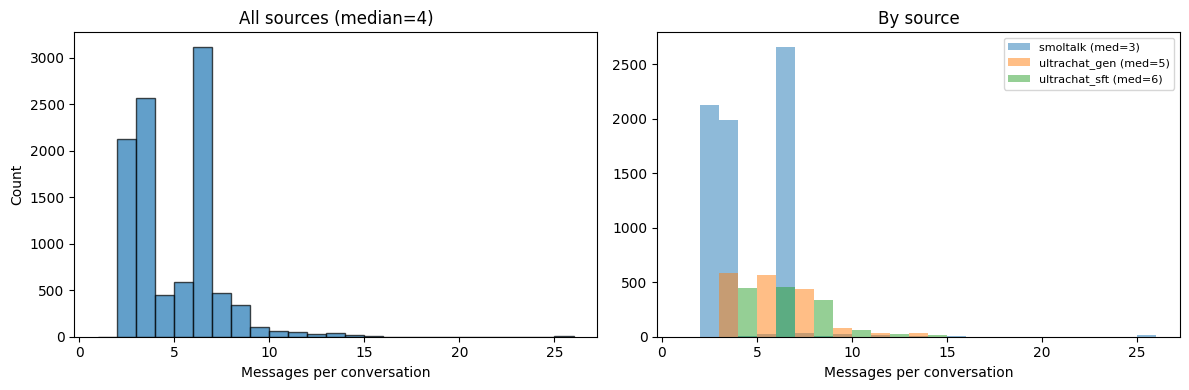

Overall: mean=4.5, median=4, min=2, max=25


In [6]:
msg_counts = [len(s['messages']) for s in samples]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(msg_counts, bins=range(1, max(msg_counts)+2), edgecolor='black', alpha=0.7)
axes[0].set_title(f'All sources (median={np.median(msg_counts):.0f})')
axes[0].set_xlabel('Messages per conversation')
axes[0].set_ylabel('Count')

# Per-source comparison
for src, rows in sorted(by_source.items()):
    counts = [len(s['messages']) for s in rows]
    axes[1].hist(counts, bins=range(1, min(max(counts)+2, 30)), alpha=0.5, label=f'{src} (med={np.median(counts):.0f})')
axes[1].set_title('By source')
axes[1].set_xlabel('Messages per conversation')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

print(f"Overall: mean={np.mean(msg_counts):.1f}, median={np.median(msg_counts):.0f}, "
      f"min={min(msg_counts)}, max={max(msg_counts)}")

## 5. Roles distribution

In [7]:
roles = Counter()
for s in samples:
    for msg in s['messages']:
        roles[msg['role']] += 1

print(f"Overall roles: {dict(roles)}")
print()

for src, rows in sorted(by_source.items()):
    src_roles = Counter(msg['role'] for s in rows for msg in s['messages'])
    print(f"{src}: {dict(src_roles)}")

Overall roles: {'user': 22409, 'assistant': 20670, 'system': 2117}

smoltalk: {'user': 12758, 'assistant': 12755, 'system': 2117}
ultrachat_gen: {'user': 5456, 'assistant': 3720}
ultrachat_sft: {'user': 4195, 'assistant': 4195}


## 6. Token length distribution (GPT-2 tokenizer)

In [8]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')

def count_tokens(sample):
    """Count total GPT-2 tokens in a conversation (text only, no special tokens)."""
    total = 0
    for msg in sample['messages']:
        total += len(tokenizer.encode(msg['content'], add_special_tokens=False))
    # Add role tokens (1 per message) + BOS + EOS
    total += len(sample['messages']) + 2
    return total

token_counts = [count_tokens(s) for s in samples]
print(f"Tokenized {len(samples)} conversations")

Token indices sequence length is longer than the specified maximum sequence length for this model (1121 > 1024). Running this sequence through the model will result in indexing errors


Tokenized 10000 conversations


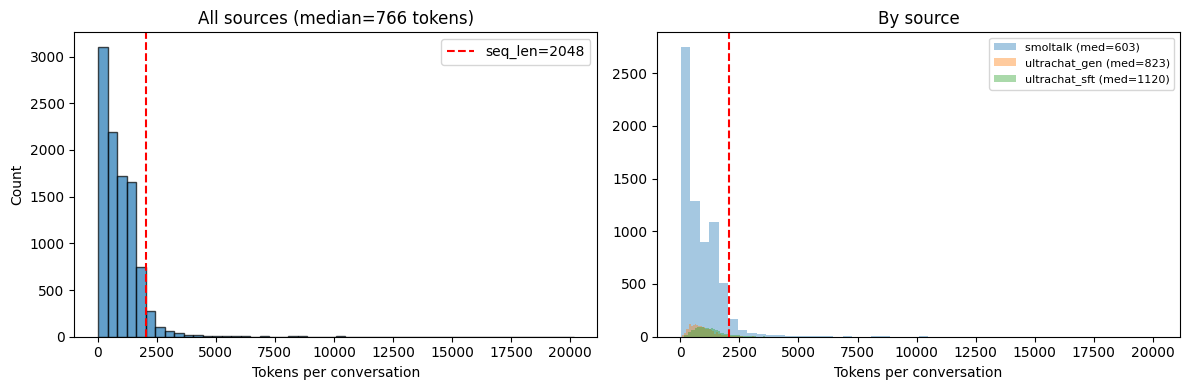

mean=943, median=766, p95=2108, max=20139
>2048: 566/10000 (5.7%)


In [9]:
arr = np.array(token_counts)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(arr, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(2048, color='red', linestyle='--', label='seq_len=2048')
axes[0].set_title(f'All sources (median={np.median(arr):.0f} tokens)')
axes[0].set_xlabel('Tokens per conversation')
axes[0].set_ylabel('Count')
axes[0].legend()

# Per-source
for src, rows in sorted(by_source.items()):
    src_tokens = [count_tokens(s) for s in rows]
    axes[1].hist(src_tokens, bins=50, alpha=0.4, label=f'{src} (med={np.median(src_tokens):.0f})')
axes[1].axvline(2048, color='red', linestyle='--')
axes[1].set_title('By source')
axes[1].set_xlabel('Tokens per conversation')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

print(f"mean={arr.mean():.0f}, median={np.median(arr):.0f}, "
      f"p95={np.percentile(arr, 95):.0f}, max={arr.max()}")
print(f">{2048}: {(arr > 2048).sum()}/{len(arr)} ({(arr > 2048).mean()*100:.1f}%)")

## 7. Total token estimate

In [10]:
mean_tokens_per_conv = arr.mean()
estimated_total_tokens = total_conversations * mean_tokens_per_conv

print("=== Total token estimate ===")
print(f"Total conversations: {total_conversations:,}")
print(f"Mean tokens/conv (sampled): {mean_tokens_per_conv:.0f}")
print(f"Estimated total tokens: {estimated_total_tokens/1e9:.2f}B")
print()

target_conv_tokens = 5e9 * 0.3  # 30% of 5B
cycles = target_conv_tokens / estimated_total_tokens
print(f"Midtraining needs: {target_conv_tokens/1e9:.1f}B conversation tokens (30% of 5B)")
print(f"Cycling factor: {cycles:.2f}x")

=== Total token estimate ===
Total conversations: 1,507,814
Mean tokens/conv (sampled): 943
Estimated total tokens: 1.42B

Midtraining needs: 1.5B conversation tokens (30% of 5B)
Cycling factor: 1.06x


## 8. Special token formatting preview

In [11]:
# Add special tokens to tokenizer (same as run_9_tokens.py --use_special_tokens)
special_tokens = {
    'bos_token': '<|beginoftext|>',
    'pad_token': '<|pad|>',
    'additional_special_tokens': ['<|user|>', '<|assistant|>', '<|system|>']
}
tokenizer.add_special_tokens(special_tokens)
print(f"Vocab size: {len(tokenizer)}")
print(f"BOS: {tokenizer.bos_token} -> {tokenizer.bos_token_id}")
print(f"EOS: {tokenizer.eos_token} -> {tokenizer.eos_token_id}")
print(f"PAD: {tokenizer.pad_token} -> {tokenizer.pad_token_id}")

user_id = tokenizer.encode('<|user|>', add_special_tokens=False)[0]
assistant_id = tokenizer.encode('<|assistant|>', add_special_tokens=False)[0]
system_id = tokenizer.encode('<|system|>', add_special_tokens=False)[0]
print(f"<|user|>: {user_id}")
print(f"<|assistant|>: {assistant_id}")
print(f"<|system|>: {system_id}")

Vocab size: 50262
BOS: <|beginoftext|> -> 50257
EOS: <|endoftext|> -> 50256
PAD: <|pad|> -> 50258
<|user|>: 50259
<|assistant|>: 50260
<|system|>: 50261


In [12]:
def format_conversation(messages, tokenizer):
    """Format a conversation with special tokens (same logic as planned ConversationStreamingDataset)."""
    role_map = {
        'user': tokenizer.encode('<|user|>', add_special_tokens=False)[0],
        'assistant': tokenizer.encode('<|assistant|>', add_special_tokens=False)[0],
        'system': tokenizer.encode('<|system|>', add_special_tokens=False)[0],
    }
    
    tokens = [tokenizer.bos_token_id]
    for msg in messages:
        role_id = role_map.get(msg['role'])
        if role_id is not None:
            tokens.append(role_id)
        content_tokens = tokenizer.encode(msg['content'], add_special_tokens=False)
        tokens.extend(content_tokens)
    tokens.append(tokenizer.eos_token_id)
    return tokens

# Show formatted examples from each source
for src, rows in sorted(by_source.items()):
    tokens = format_conversation(rows[0]['messages'], tokenizer)
    print(f"=== {src} (first 80 tokens) ===")
    print(f"Decoded: {tokenizer.decode(tokens[:80])}")
    print(f"Total tokens: {len(tokens)}")
    print()

=== smoltalk (first 80 tokens) ===
Decoded: <|beginoftext|><|user|>Erin is watching a TV mini series of Pride and Prejudice. There are 6 episodes that are each 50 minutes long. If Erin watches all of the episodes in one sitting, one after the other with no breaks, how many hours will she spend watching the series?<|assistant|>There are 6 episodes in total and each episode is 50 minutes long.
To find the total time Erin spends
Total tokens: 164

=== ultrachat_gen (first 80 tokens) ===
Decoded: <|beginoftext|><|user|>1. Unplug the toaster and let it cool down completely before cleaning.<|assistant|>2. Remove the crumb tray and empty any crumbs into the garbage. 

3. Wash the crumb tray in warm, soapy water and dry it thoroughly before replacing it. 

4. Use a damp cloth to wipe down the outside of the toaster, being careful
Total tokens: 437

=== ultrachat_sft (first 80 tokens) ===
Decoded: <|beginoftext|><|user|>Given the text: Haiku: a poem recording the essence of a moment keen percei

## 9. Source distribution (full dataset)

In [13]:
# Count sources across ALL rows (not just sample)
all_sources = Counter(row.get('source', 'unknown') for row in all_rows)
print("Source distribution (full dataset):")
for source, count in all_sources.most_common():
    print(f"  {source}: {count:>10,} ({count/total_conversations*100:.1f}%)")
print(f"  {'TOTAL'}: {total_conversations:>10,}")

Source distribution (full dataset):
  smoltalk:  1,043,917 (69.2%)
  ultrachat_gen:    256,032 (17.0%)
  ultrachat_sft:    207,865 (13.8%)
  TOTAL:  1,507,814


## 10. Summary

In [14]:
print("=" * 60)
print("MIDTRAINING DATA SUMMARY")
print("=" * 60)
print()
print(f"Shards: {len(parquet_files)}")
print(f"Total conversations: {total_conversations:,}")
print(f"Mean tokens/conv: {mean_tokens_per_conv:.0f}")
print(f"Estimated total tokens: {estimated_total_tokens/1e9:.2f}B")
print()
print(f"Target conversation tokens: {target_conv_tokens/1e9:.1f}B (30% of 5B)")
print(f"Estimated cycling: {cycles:.2f}x")
print(f"Format: messages: [{{content, role}}]")
print(f"Roles: {', '.join(sorted(roles.keys()))}")
print(f"Sources: {', '.join(sorted(all_sources.keys()))}")

MIDTRAINING DATA SUMMARY

Shards: 31
Total conversations: 1,507,814
Mean tokens/conv: 943
Estimated total tokens: 1.42B

Target conversation tokens: 1.5B (30% of 5B)
Estimated cycling: 1.06x
Format: messages: [{content, role}]
Roles: assistant, system, user
Sources: smoltalk, ultrachat_gen, ultrachat_sft
